In [1]:
#To get detailed description if get CUDA error
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

In [2]:
import os
os.chdir('../')
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

In [3]:
import scanpy as sc
import torch
import scarches as sca
from scarches.dataset.trvae.data_handling import remove_sparsity
import matplotlib.pyplot as plt
import numpy as np
import gdown
import time

/home/mohammed/anaconda3/envs/scib_metrics/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
 captum (see https://github.com/pytorch/captum).
INFO:lightning_fabric.utilities.seed:Global seed set to 0


In [4]:
st = time.time()

In [5]:
sc.settings.set_figure_params(dpi=200, frameon=False)
sc.set_figure_params(dpi=200)
sc.set_figure_params(figsize=(4, 4))
torch.set_printoptions(precision=3, sci_mode=False, edgeitems=7)

In [6]:
url = 'https://drive.google.com/uc?id=1Vh6RpYkusbGIZQC8GMFe3OKVDk5PWEpC'
output = 'pbmc.h5ad'
gdown.download(url, output, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1Vh6RpYkusbGIZQC8GMFe3OKVDk5PWEpC
To: /home/mohammed/saved_models/pbmc.h5ad
100%|██████████████████████████████████████████████████████████████████████████████| 2.06G/2.06G [05:07<00:00, 6.71MB/s]


'pbmc.h5ad'

In [7]:
adata = sc.read('pbmc.h5ad')
# adata = sc.pp.subsample(adata, fraction=None, n_obs=5000, random_state=0, copy=True)

In [8]:
adata.X = adata.layers["counts"].copy()

In [9]:
condition_key = 'batch'
target_conditions = ['10X']

trvae_epochs = 500
surgery_epochs = 500

early_stopping_kwargs = {
    "early_stopping_metric": "val_unweighted_loss",
    "threshold": 0,
    "patience": 20,
    "reduce_lr": True,
    "lr_patience": 13,
    "lr_factor": 0.1,
}

In [10]:
target_conditions = ["10X"]
removed_dataset = ['10X', 'Villani']
removed_viallni = ['Villani']
chosen_source = ['Freytag']
adata_villani_removed = adata[~adata.obs.study.isin(removed_viallni)].copy()
source_adata = adata_villani_removed[adata_villani_removed.obs.study.isin(chosen_source)].copy()
source_conditions = source_adata.obs[condition_key].unique().tolist()
print(source_adata, source_conditions)
print(adata_villani_removed.obs['batch'])

AnnData object with n_obs × n_vars = 3347 × 12303
    obs: 'batch', 'chemistry', 'data_type', 'dpt_pseudotime', 'final_annotation', 'mt_frac', 'n_counts', 'n_genes', 'sample_ID', 'size_factors', 'species', 'study', 'tissue'
    layers: 'counts' ['Freytag']
index
AAACCTGCAGCGAACA-1-Oetjen_A                Oetjen_A
AAACCTGCATGTCCTC-1-Oetjen_A                Oetjen_A
AAACCTGGTCGACTGC-1-Oetjen_A                Oetjen_A
AAACCTGGTCGCTTCT-1-Oetjen_A                Oetjen_A
AAACCTGTCCCGACTT-1-Oetjen_A                Oetjen_A
                                          ...      
TTTGTCAAGCTCCTTC-1-Sun_sample4_TC    Sun_sample4_TC
TTTGTCAAGCTGAAAT-1-Sun_sample4_TC    Sun_sample4_TC
TTTGTCATCATCATTC-1-Sun_sample4_TC    Sun_sample4_TC
TTTGTCATCTCGCTTG-1-Sun_sample4_TC    Sun_sample4_TC
TTTGTCATCTGTCTCG-1-Sun_sample4_TC    Sun_sample4_TC
Name: batch, Length: 32484, dtype: category
Categories (9, object): ['10X', 'Freytag', 'Oetjen_A', 'Oetjen_P', ..., 'Sun_sample1_CS', 'Sun_sample2_KC', 'Sun_sample3_

In [11]:
adata_tasks = adata_villani_removed[~adata_villani_removed.obs.study.isin(chosen_source)].copy()
adata_tasks_obs = adata_tasks.obs['batch']
tasks_list = list(set(adata_tasks_obs))
tasks_list

['Oetjen_A',
 'Sun_sample1_CS',
 'Sun_sample4_TC',
 'Sun_sample3_TB',
 'Sun_sample2_KC',
 'Oetjen_P',
 'Oetjen_U',
 '10X']

In [12]:
source_adata.raw = source_adata

In [13]:
source_adata

AnnData object with n_obs × n_vars = 3347 × 12303
    obs: 'batch', 'chemistry', 'data_type', 'dpt_pseudotime', 'final_annotation', 'mt_frac', 'n_counts', 'n_genes', 'sample_ID', 'size_factors', 'species', 'study', 'tissue'
    layers: 'counts'

In [14]:
sc.pp.normalize_total(source_adata)

In [15]:
sc.pp.log1p(source_adata)

In [16]:
sc.pp.highly_variable_genes(
    source_adata,
    n_top_genes=2000,
    batch_key="batch",
    subset=True)

In [17]:
source_adata.X = source_adata.raw[:, source_adata.var_names].X

In [18]:
source_adata

AnnData object with n_obs × n_vars = 3347 × 2000
    obs: 'batch', 'chemistry', 'data_type', 'dpt_pseudotime', 'final_annotation', 'mt_frac', 'n_counts', 'n_genes', 'sample_ID', 'size_factors', 'species', 'study', 'tissue'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: 'log1p', 'hvg'
    layers: 'counts'

In [19]:
trvae = sca.models.TRVAE(
    adata=source_adata,
    condition_key=condition_key,
    conditions=source_conditions,
    hidden_layer_sizes=[128, 128],
)


INITIALIZING NEW NETWORK..............
	Input Layer in, out and cond: 2000 128 1
	Hidden Layer 1 in/out: 128 128
	Mean/Var Layer in/out: 128 10
Decoder Architecture:
	First Layer in, out and cond:  10 128 1
	Hidden Layer 1 in/out: 128 128
	Output Layer in/out:  128 2000 



In [20]:
trvae.train(
    n_epochs=trvae_epochs,
    alpha_epoch_anneal=200,
    early_stopping_kwargs=early_stopping_kwargs,
    ID=0,
    learning_approach='latent replay',
)

latent replay is happening!
 |████----------------| 23.2%  - val_loss: 457.0139363607 - val_recon_loss: 453.5393168132 - val_kl_loss: 6.0428277651 - val_mmd_loss: 0.00000000000
ADJUSTED LR
 |████----------------| 24.6%  - val_loss: 441.0645141602 - val_recon_loss: 437.3930460612 - val_kl_loss: 6.0188013713 - val_mmd_loss: 0.0000000000
Stopping early: no improvement of more than 0 nats in 20 epochs
If the early stopping criterion is too strong, please instantiate it with different parameters in the train method.
Saving best state of network...
Best State was in Epoch 101


In [21]:
adata_latent = sc.AnnData(trvae.get_latent())
adata_latent.obs["cell_type"] = source_adata.obs["final_annotation"].tolist()
adata_latent.obs["batch"] = source_adata.obs["batch"].tolist()

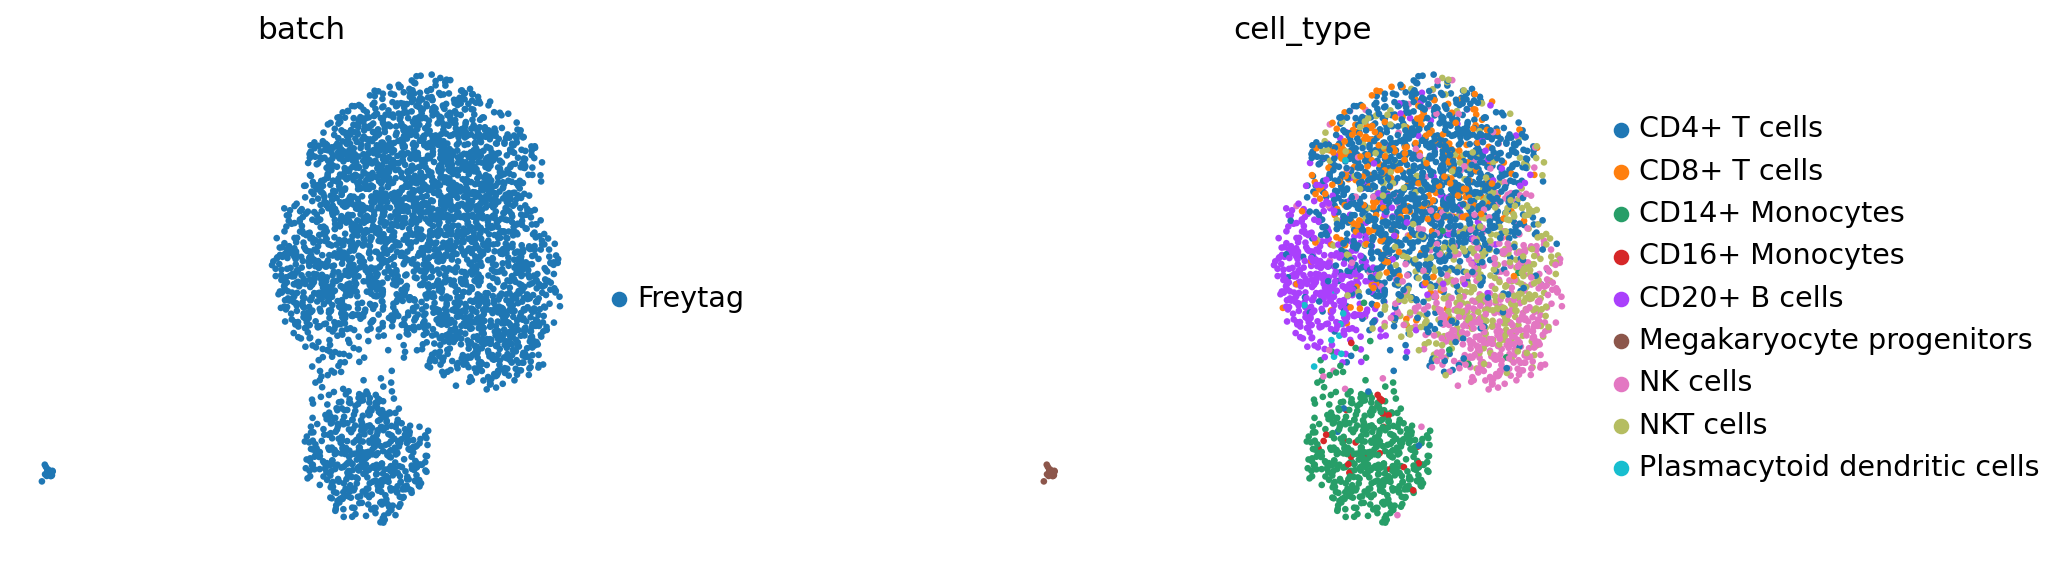

In [22]:
sc.pp.neighbors(adata_latent, n_neighbors=8)
sc.tl.leiden(adata_latent)
sc.tl.umap(adata_latent)
sc.pl.umap(adata_latent,
           color=['batch', 'cell_type'],
           frameon=False,
           wspace=0.6,
           )

In [23]:
ref_path = 'reference_model_PBMC/'
trvae.save(ref_path, overwrite=True)

In [24]:
for ID, task in enumerate(tasks_list, start=1): #adata_tasks[1:] if you wanna skip the first item
    print(ID, task)
    task_i = adata_tasks[adata_tasks.obs['batch'].isin([task])]
    task_i = task_i[:, source_adata.var_names]
    new_trvae_LR_1 = sca.models.TRVAE.load_query_data(adata=task_i,
                                                 learning_approach = 'latent replay',
                                                 model=ref_path)
    new_trvae_LR_1.train(
    n_epochs=surgery_epochs,
    alpha_epoch_anneal=200,
    early_stopping_kwargs=early_stopping_kwargs,
    ID=ID,
    weight_decay=0,
    learning_approach = 'latent replay'
    )
    
    ref_path = 'reference_model_PBMC/'
    new_trvae_LR_1.save(ref_path, overwrite=True)

1 Oetjen_A
View of AnnData object with n_obs × n_vars = 2586 × 2000
    obs: 'batch', 'chemistry', 'data_type', 'dpt_pseudotime', 'final_annotation', 'mt_frac', 'n_counts', 'n_genes', 'sample_ID', 'size_factors', 'species', 'study', 'tissue'
    layers: 'counts'

INITIALIZING NEW NETWORK..............
	Input Layer in, out and cond: 2000 128 2
	Hidden Layer 1 in/out: 128 128
	Mean/Var Layer in/out: 128 10
Decoder Architecture:
	First Layer in, out and cond:  10 128 2
	Hidden Layer 1 in/out: 128 128
	Output Layer in/out:  128 2000 

latent replay is happening!
 |█-------------------| 8.8%  - val_loss: 717.1735636393 - val_recon_loss: 713.4962361654 - val_kl_loss: 17.1038150787 - val_mmd_loss: 0.0000000000
ADJUSTED LR
 |██------------------| 10.2%  - val_loss: 764.2741495768 - val_recon_loss: 760.0012003581 - val_kl_loss: 17.0918045044 - val_mmd_loss: 0.0000000000
Stopping early: no improvement of more than 0 nats in 20 epochs
If the early stopping criterion is too strong, please instanti

 |████----------------| 23.0%  - val_loss: 513.9253641764 - val_recon_loss: 508.5999552409 - val_kl_loss: 9.3428163528 - val_mmd_loss: 0.00000000000
ADJUSTED LR
 |█████---------------| 27.0%  - val_loss: 513.6836649577 - val_recon_loss: 507.5093892415 - val_kl_loss: 9.2153313955 - val_mmd_loss: 0.0000000000
ADJUSTED LR
 |██████--------------| 30.4%  - val_loss: 513.8218078613 - val_recon_loss: 506.9190572103 - val_kl_loss: 9.1427005132 - val_mmd_loss: 0.0000000000
ADJUSTED LR
 |██████--------------| 31.8%  - val_loss: 513.5339864095 - val_recon_loss: 506.3172810872 - val_kl_loss: 9.1350765228 - val_mmd_loss: 0.0000000000
Stopping early: no improvement of more than 0 nats in 20 epochs
If the early stopping criterion is too strong, please instantiate it with different parameters in the train method.
Saving best state of network...
Best State was in Epoch 137
8 10X
View of AnnData object with n_obs × n_vars = 10727 × 2000
    obs: 'batch', 'chemistry', 'data_type', 'dpt_pseudotime', 'fina

In [25]:
target_adata = adata_villani_removed[~adata_villani_removed.obs.study.isin(chosen_source)].copy()
target_adata = target_adata[:, source_adata.var_names]
target_adata

View of AnnData object with n_obs × n_vars = 29137 × 2000
    obs: 'batch', 'chemistry', 'data_type', 'dpt_pseudotime', 'final_annotation', 'mt_frac', 'n_counts', 'n_genes', 'sample_ID', 'size_factors', 'species', 'study', 'tissue'
    layers: 'counts'

In [26]:
adata_full = source_adata.concatenate(target_adata, batch_key="ref_query")
adata_full

AnnData object with n_obs × n_vars = 32484 × 2000
    obs: 'batch', 'chemistry', 'data_type', 'dpt_pseudotime', 'final_annotation', 'mt_frac', 'n_counts', 'n_genes', 'sample_ID', 'size_factors', 'species', 'study', 'tissue', 'ref_query'
    var: 'highly_variable-0', 'means-0', 'dispersions-0', 'dispersions_norm-0', 'highly_variable_nbatches-0', 'highly_variable_intersection-0'
    layers: 'counts'

In [27]:
full_latent = sc.AnnData(new_trvae_LR_1.get_latent(adata_full.X, adata_full.obs[condition_key]))
full_latent.obs['cell_type'] = adata_full.obs["final_annotation"].tolist()
full_latent.obs['batch'] = adata_full.obs["batch"].tolist()

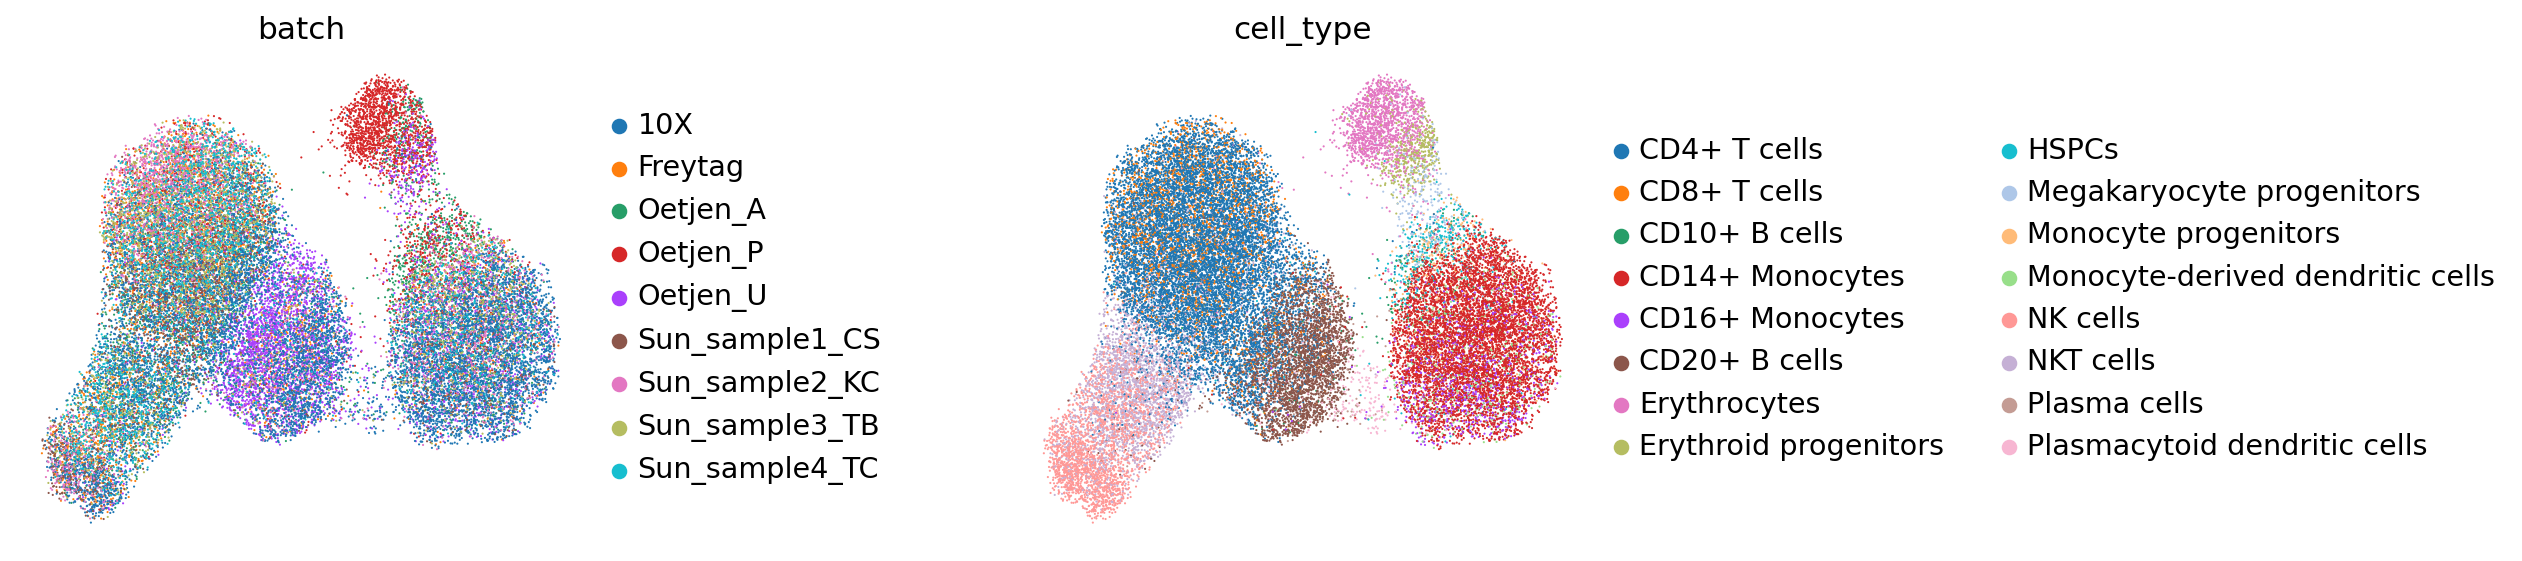

In [28]:
sc.pp.neighbors(full_latent, n_neighbors=8)
sc.tl.leiden(full_latent)
sc.tl.umap(full_latent)
sc.pl.umap(full_latent,
           color=['batch', 'cell_type'],
           frameon=False,
           wspace=0.6,
           )

In [29]:
X_LR_1 = new_trvae_LR_1.get_latent(adata_full.X, adata_full.obs[condition_key])
%store X_LR_1

Stored 'X_LR_1' (ndarray)


In [30]:
elapsed_time = time.time() - st
print('Execution time:', time.strftime("%H:%M:%S", time.gmtime(elapsed_time)))

Execution time: 04:02:19


In [31]:
import scanpy
import scib
arches_nb_graph=sc.pp.neighbors(full_latent, n_neighbors=8, n_pcs=None, use_rep='X')
Batch_corr_graph_LR_1=scib.metrics.graph_connectivity(full_latent, 'batch')
Batch_corr_graph_LR_1

0.684547964558553

In [32]:
sc.tl.umap(full_latent)
Batch_corr_ASW_LR_1=scib.metrics.silhouette_batch(full_latent, batch_key='batch', group_key='cell_type', embed='X_umap')
Batch_corr_ASW_LR_1

/tmp/ipykernel_223/1009180439.py:2: DeprecationWarning: Keyword argument 'group_key' has been deprecated in favour of 'label_key'. 'group_key' will be removed in a future version.
  Batch_corr_ASW_LR_1=scib.metrics.silhouette_batch(full_latent, batch_key='batch', group_key='cell_type', embed='X_umap')


mean silhouette per group:                                   silhouette_score
group                                             
CD10+ B cells                             0.815328
CD14+ Monocytes                           0.911604
CD16+ Monocytes                           0.868408
CD20+ B cells                             0.838653
CD4+ T cells                              0.795466
CD8+ T cells                              0.818179
Erythrocytes                              0.768148
Erythroid progenitors                     0.937993
HSPCs                                     0.900763
Megakaryocyte progenitors                 0.832964
Monocyte progenitors                      0.875881
Monocyte-derived dendritic cells          0.900258
NK cells                                  0.742525
NKT cells                                 0.816058
Plasma cells                              0.846149
Plasmacytoid dendritic cells              0.826144


0.8434076051707312

In [33]:
Bio_cons_ASW_LR_1=scib.metrics.silhouette(full_latent, group_key='cell_type', embed='X_umap')
Bio_cons_ASW_LR_1

/tmp/ipykernel_223/1659356728.py:1: DeprecationWarning: Keyword argument 'group_key' has been deprecated in favour of 'label_key'. 'group_key' will be removed in a future version.
  Bio_cons_ASW_LR_1=scib.metrics.silhouette(full_latent, group_key='cell_type', embed='X_umap')


0.48647959250956774

In [34]:
isolated_labels_LR_1=scib.metrics.isolated_labels(full_latent, label_key='cell_type', batch_key='batch', embed='X_umap')
isolated_labels_LR_1

isolated labels: no more than 3 batches per label
Compute neighbors on rep X_umap
CD10+ B cells: 0.1693548387096774
Compute neighbors on rep X_umap
Erythrocytes: 0.8089025326170376
Compute neighbors on rep X_umap
Erythroid progenitors: 0.579020979020979
Compute neighbors on rep X_umap
Monocyte progenitors: 0.24663677130044842


0.45097878041203565

In [35]:
pcr_LR_1=scib.metrics.pcr_comparison(source_adata, adata, covariate='batch', embed=None, n_comps=50, scale=False, verbose=False)
pcr_LR_1

0.6530575501015305